<a href="https://colab.research.google.com/github/drkrillo/DATASCIENCE/blob/main/DS_03_NLP_Pasutti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 16.2 MB 8.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import itertools
import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
import seaborn as sns
import os
import re
from unicodedata import normalize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#train = pd.read_json('dataset_es_train.json', lines = True)
#print(train.head(), '\n', train.shape)

#dev = pd.read_json('dataset_es_dev.json', lines = True)
#print(dev.head(), '\n', train.shape)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/DATASCIENCE

/content/gdrive/MyDrive/DATASCIENCE


In [ ]:
train = pd.read_json('dataset_es_train.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
dev = pd.read_json('dataset_es_dev.json', lines = True)

In [ ]:
train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [ ]:
dev.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

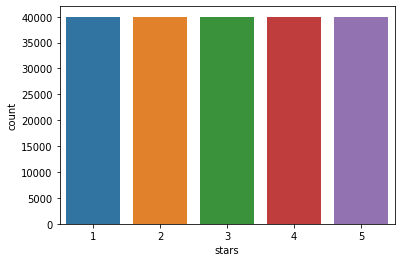

In [ ]:
sns.countplot(x = train.stars)

In [ ]:
test = pd.read_json('dataset_es_test.json', lines = True)
print(test.head(), '\n', test.shape)

    review_id          product_id  ... language        product_category
0  es_0038754  product_es_0113523  ...       es                wireless
1  es_0748979  product_es_0017036  ...       es                    home
2  es_0411746  product_es_0138642  ...       es                     toy
3  es_0786686  product_es_0170887  ...       es                    home
4  es_0429700  product_es_0710642  ...       es  digital_ebook_purchase

[5 rows x 8 columns] 
 (5000, 8)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


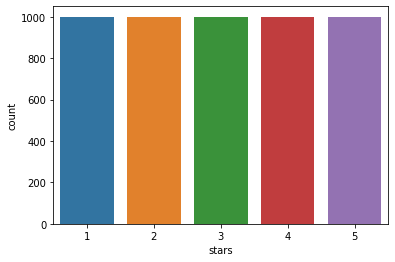

In [ ]:
sns.countplot(test.stars)

In [ ]:
test.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [ ]:
train.describe()

,stars
count,200000.000000
mean,3.000000
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
test.describe()

,stars
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
stopwords = stopwords.words('spanish')

In [ ]:
s = train.iloc[2,4]

In [ ]:
words = nltk.word_tokenize(s)
words=[word.lower() for word in words if word.isalpha()]
s

'Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!'

In [ ]:
words

['te',
 'obligan',
 'a',
 'comprar',
 'dos',
 'unidades',
 'y',
 'te',
 'llega',
 'solo',
 'una',
 'y',
 'no',
 'hay',
 'forma',
 'de',
 'reclamar',
 'una',
 'autentica',
 'estafa',
 'no',
 'compreis']

In [ ]:
titular_wt_sin_sw = [p for p in words if p not in stopwords]
titular_wt_sin_sw

['obligan',
 'comprar',
 'dos',
 'unidades',
 'llega',
 'solo',
 'forma',
 'reclamar',
 'autentica',
 'estafa',
 'compreis']

FUNCA BIEN, TRATEMOS DE VER QUE ONDA TRANSFORMANDO TODOS LOS DATOS DE TRAIN Y CONTANDO CRECUENCIAS

VAMOS A PROBAR CON EL TITULO, QUE PARECE ESTAR DANDO INFORMACION IMPORTANTE. eS MAS CORTO, CAPAZ ES MEJOR.

In [ ]:
def stemmer(array):
    stemm = []

    for i in range(array.shape[0]):
        titular = array.iloc[i].review_title #seleccionar el titular
        words = nltk.word_tokenize(titular)
        titular = [word.lower() for word in words if word.isalpha()]
        titular = [x for x in titular if x not in stopwords] # Filtrar por stopwords
        titular = [PorterStemmer().stem(x) for x in titular]
        titular = " ".join(titular)
        stemm.append(titular)
    return stemm

In [ ]:
stemm_train = stemmer(train)

In [ ]:
train["stemm_title"] = stemm_train
print(train.head(), train.tail())

    review_id  ...                           stemm_title
0  es_0491108  ...                         televis nevir
1  es_0869872  ...           dinero tirado basura compra
2  es_0811721  ...  solo llega unidad obligan comprar do
3  es_0359921  ...                     producto recibido
4  es_0068940  ...                              devuelto

[5 rows x 9 columns]          review_id          product_id  ... product_category            stemm_title
199995  es_0715276  product_es_0317036  ...      electronics            tal describ
199996  es_0085190  product_es_0622919  ...      electronics  funciona perfectament
199997  es_0484496  product_es_0358101  ...          apparel          buena calidad
199998  es_0930141  product_es_0788855  ...              toy            recomendado
199999  es_0859809  product_es_0378794  ...             home               preciosa

[5 rows x 9 columns]


vemos que hay problemas con algunos de los stemms. NLTK no lemmatiza sobre español, asique vamos a ver que onda con los modelos y sino usamos Spacy

Normalizamos y stemmizamos los titulos de test.

In [ ]:
stemm_test = stemmer(test)
test["stemm_title"] = stemm_test
print(test.head(), test.tail())

stemm_dev = stemmer(dev)
dev["stemm_title"] = stemm_test
dev = dev[['review_title', 'stemm_title', 'stars']]
print(test.head(), test.tail())

    review_id  ...                   stemm_title
0  es_0038754  ...                         llego
1  es_0748979  ...   amazon sigu cumplir entrega
2  es_0411746  ...                  estafa envío
3  es_0786686  ...                 estafa amazon
4  es_0429700  ...  conseguí pasar portada kindl

[5 rows x 9 columns]        review_id  ...                 stemm_title
4995  es_0685611  ...             perfecto sirven
4996  es_0638242  ...  buen vendedor rápido fiabl
4997  es_0760108  ...      medalla bonito grabado
4998  es_0070806  ...                       timbr
4999  es_0794544  ...       auricular cabl verdad

[5 rows x 9 columns]
    review_id  ...                   stemm_title
0  es_0038754  ...                         llego
1  es_0748979  ...   amazon sigu cumplir entrega
2  es_0411746  ...                  estafa envío
3  es_0786686  ...                 estafa amazon
4  es_0429700  ...  conseguí pasar portada kindl

[5 rows x 9 columns]        review_id  ...                 stemm_ti

In [ ]:
X_train = train[['stemm_title', 'stars']]
X_dev = dev[['stemm_title', 'stars']]
X_test = test[['stemm_title', 'stars']]

In [ ]:
list_titulos_train = list(X_train['stemm_title'].values)
stars_train = X_train['stars'].values

In [ ]:
list_titulos_test = list(X_test['stemm_title'].values)
stars_test = X_test['stars'].values

In [ ]:
list_titulos_dev = list(X_dev['stemm_title'].values)
stars_dev = X_dev['stars'].values

In [ ]:
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) 

In [ ]:
matriz_titulos_train = cou_vec.fit_transform(list_titulos_train)
matriz_titulos_test = cou_vec.fit_transform(list_titulos_test)
matriz_titulos_dev = cou_vec.fit_transform(list_titulos_dev)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abierta', 'abierto', 'acabado', 'aceit', 'acept', 'acierto', 'acopla', 'acuario', 'adapta', 'adaptador', 'adecuada', 'adecuado', 'adhesivo', 'adulto', 'agrad', 'agua', 'ajusta', 'alarma', 'alfombrilla', 'alguna', 'altavoz', 'alto', 'amazon', 'ana', 'ancho', 'antena', 'anti', 'antonio', 'anuncia', 'anuncio', 'aparato', 'appl', 'apuro', 'articulo', 'artículo', 'asequ', 'aspecto', 'atención', 'atractivo', 'audio', 'aunqu', 'azul', 'año', 'aún', 'baja', 'band', 'barata', 'barato', 'base', 'bastant']


Esta acaba y acabado, alta, altura y alto, : no anda bien el stemming con nltk


In [ ]:
xtrain = matriz_titulos_train.toarray()
ytrain = stars_train
xtest = matriz_titulos_test.toarray()
ytest = stars_test
xdev = matriz_titulos_dev.toarray()
ydev = stars_dev

xtrain.shape

(200000, 1000)

In [ ]:
def confusion(ytest,y_pred):
    names=["1","2",'3','4','5']
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    return

In [ ]:
def tokener(array):
    tokener = []

    for i in range(array.shape[0]):
        titular = array.iloc[i].review_title #seleccionar el titular
        titular = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", titular), 0, re.I
        )
        titular = normalize( 'NFC', titular)
        words = nltk.word_tokenize(titular)
        titular = [word.lower() for word in words if word.isalpha()]
        titular = [x for x in titular if x not in stopwords] # Filtrar por stopwords
        titular = [PorterStemmer().stem(x) for x in titular]
        tokener.append(titular)
    return tokener

In [ ]:
xtrain = tokener(train)

In [ ]:
xtest = tokener(test)
xdev = tokener(dev)

In [ ]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

xtrain_tfidf = tfidf.fit_transform(xtrain)
xtest_tfidf = tfidf.transform(xtest)
xdev_tfidf = tfidf.transform(xdev)

In [ ]:
#xgb = XGBClassifier(n_estimators = 1000,
#                    max_depth = 3,
#                    learning_rate = 0.1,
#                   tree_method='gpu_hist')
#xgb.fit(xtrain_tfidf,ytrain)
#y_tr_p = xgb.predict(xtrain_tfidf)
#y_d_p = xgb.predict(xdev_tfidf)
#print(accuracy_score(ydev, y_d_p))
#confusion(ytest, y_d_p)

In [ ]:
import spacy
import string
from spacy.lang.es import Spanish
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.es.stop_words import STOP_WORDS

In [ ]:
nlp = spacy.load('es_core_news_sm')
stopwords = nlp.Defaults.stop_words

In [ ]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", sentence), 0, re.I
        )
    mytokens = normalize( 'NFC', mytokens)
    mytokens = nlp(mytokens)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stopwords]

    # return preprocessed list of tokens
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [ ]:
nlp = spacy.load('es_core_news_sm')
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
dev = pd.read_json('dataset_es_dev.json', lines = True)
X = train.review_body
y = train.stars
Xdev = dev.review_body
ydev = dev.stars
classifier = RandomForestClassifier()

In [ ]:
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
# Predicting with a test dataset
pipe.fit(X, y)
predicted = pipe.predict(Xdev)

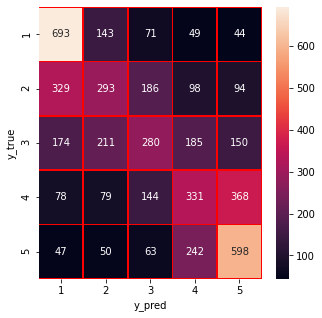

None
RF Classifier Accuracy: 0.439
RF Classifier Precision: 0.4242287677920479
RF Classifier Recall: 0.439


In [ ]:
print(confusion(ydev, predicted))
print("RF Classifier Accuracy:",metrics.accuracy_score(ydev, predicted))
print("RF Classifier Precision:",metrics.precision_score(ydev, predicted, average  = 'weighted'))
print("RF Classifier Recall:",metrics.recall_score(ydev, predicted, average = 'weighted'))

In [ ]:
y = (y >= 4).astype(int)

In [ ]:
ydev = (ydev >= 4).astype(int)

In [ ]:
pipe.fit(X,y)
predicted2 = pipe.predict(Xdev)

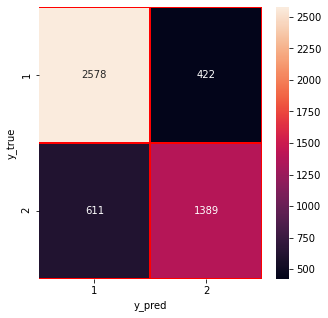

None
RF Classifier Accuracy: 0.7934
RF Classifier Precision: 0.76697956929873
RF Classifier Recall: 0.6945


In [ ]:
print(confusion(ydev, predicted2))
print("RF Classifier Accuracy:",metrics.accuracy_score(ydev, predicted2))
print("RF Classifier Precision:",metrics.precision_score(ydev, predicted2))
print("RF Classifier Recall:",metrics.recall_score(ydev, predicted2))

In [ ]:
import lightgbm as lgb 
classifier = lgb.LGBMClassifier()
pipe.fit(X, y)
predicted3 = pipe.predict(Xdev)

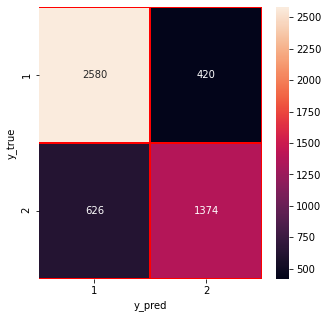

None
RF Classifier Accuracy: 0.7908
RF Classifier Precision: 0.7658862876254181
RF Classifier Recall: 0.687


In [ ]:
print(confusion(ydev, predicted3))
print("RF Classifier Accuracy:",metrics.accuracy_score(ydev, predicted3))
print("RF Classifier Precision:",metrics.precision_score(ydev, predicted3))
print("RF Classifier Recall:",metrics.recall_score(ydev, predicted3))